In [1]:
import json
import pickle
import re
import time

from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Collecting HTML pages

In [164]:
headers = {'User-Agent': "Mozilla/5.0 (Linux; SM-G955U Build/R16NW) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0"}

In [ ]:
i = 1
while i > 0:
    url = f"https://www.mudah.my/malaysia/cars-for-sale/honda?o={i}"
    req = Request(url, headers=headers)
    res = urlopen(req).read()
    soup = BeautifulSoup(res, "html.parser")
    regex = re.compile('listing-ad-item.*')
    car_list = soup.find_all('div', {'data-testid' : regex})
    
    if len(car_list) > 0:
        f = open(f"page_{i}.html", "w", encoding="utf-8")
        f.write(str(soup))
        f.close()
        print(f"page {i} is saved; count: {len(car_list)}")
    else:
        break
    i += 1
    time.sleep(10)

# Data scraping from HTML pages

In [2]:
def get_year(car_soup):
    content = car_soup.find('div', {'title' : 'Manufactured Year'})
    if content:
        year = content.find("div").text
        return year
    content = car_soup.find('div', {'data-testid' : 'year-verified-badge'})
    if content:
        year = content.find("div").text
        return year
    return np.nan

def get_mileage(car_soup):
    try:
        mileage = car_soup.find('div', {'title' : 'Mileage'})
        m = mileage.find("div").text
        return m
    except:
        return np.nan

def get_name(car_soup):
    name = car_soup.find('a')
    if name:
        return name['title']
    return np.nan

def get_url(car_soup):
    name = car_soup.find('a')
    if name:
        return name['href']
    return np.nan

def get_location(car_soup):
    c = car_soup.find('span', {'title' : 'Region'})
    if c:
        r = c.find("span")
        return r.text
    return np.nan

In [3]:
data = []
car_regex = re.compile('listing-ad-item.*')

for page in range(1, 101):
    html_file = open(f"html_pages/page_{page}.html", "r", encoding="utf-8")
    html_value = html_file.read()
    soup = BeautifulSoup(html_value, "html.parser")
    
    car_soup_1 = soup.find_all('div', {'data-testid' : car_regex})
    car_soup_2 = soup.find('script', {'type' : 'application/ld+json'})
    cars_json = json.loads(car_soup_2.text)
    car_list = cars_json[2]['itemListElement']

    assert len(car_soup_1) == cars_json[2]['numberOfItems']

    for i in range(len(car_soup_1)):
        url = get_url(car_soup_1[i])
        assert url == car_list[i]['item']['url']
        
        year = get_year(car_soup_1[i])
        mileage = get_mileage(car_soup_1[i])
        price = car_list[i]['item']['offers']['price']
        name = get_name(car_soup_1[i])
        loc = get_location(car_soup_1[i])
        url = get_url(car_soup_1[i])

        row = {
            "year": year,
            "name": name,
            "price": price,
            "mileage": mileage,
            "location": loc,
            "page": page,
            "url": url,
        }
        data.append(row)

df = pd.DataFrame(data)
convert_dict = {'year': int, 'price': float}
df = df.astype(convert_dict)

In [4]:
df.head()

,year,name,price,mileage,location,page,url
0,2023,2023 Honda CIVIC 2.0 TYPE R MY23 FL5 (M),298000.0,10000 - 14999,Kuala Lumpur,1,https://www.mudah.my/2023-honda-civic-2-0-type...
1,2014,2014 Honda CITY 1.5 E FACELIFT (A) FULL ACCESSORY,33900.0,90000 - 94999,Penang,1,https://www.mudah.my/2014-honda-city-1-5-e-fac...
2,2019,2019 Honda CITY 1.5 (A) PRICE CORET UNTUNG 1K JA,49900.0,60000 - 64999,Penang,1,https://www.mudah.my/2019-honda-city-1-5-a-pri...
3,2015,2015 Honda HR-V 1.8 V (A) KEYLESS PUSHSTART F/...,41800.0,130000 - 139999,Kuala Lumpur,1,https://www.mudah.my/2015-honda-hr-v-1-8-v-a-k...
4,2018,2018 Honda CITY 1.5 HYB (A) 3YRS WARRANTY H/LOAN,45999.0,55000 - 59999,Johor,1,https://www.mudah.my/2018-honda-city-1-5-hyb-a...


In [5]:
len(df)

4000

# Data preprocessing

In [8]:
# collect a list of car models
html_file = open("html_pages/page_1.html", "r", encoding="utf-8")
html_value = html_file.read()
soup = BeautifulSoup(html_value, "html.parser")
models_soup = soup.find('ul', {'data-testid' : 'model_id-filter-dropdown'})
models_soup = models_soup.find_all('li')
models = []

for i in range(1, len(models_soup)):
    models.append(models_soup[i].text)

models.remove("E")
models.remove("Z")

In [9]:
def generate_model(row):
    for m in models:
        if m.lower() in row['name'].lower():
            return m.lower()
    return np.nan

df['model'] = df.apply(generate_model, axis=1)

In [10]:
def generate_mid_mileage(row):
    m_split = row['mileage'].strip().split('-')
    mid = float(m_split[0]) + (float(m_split[1]) - float(m_split[0])) / 2
    return mid
    
df['mileage_mid'] = df.apply(generate_mid_mileage, axis=1)

In [12]:
df.dropna(inplace=True)

In [13]:
# save into csv
df.to_csv('honda_used_cars.csv', index=False) 

# Stats

In [16]:
len(df)

3982

In [17]:
# group by model
df.groupby(['model'])['model'].count().sort_values(ascending=False)

model
civic        1096
city          943
hr-v          432
cr-v          427
accord        332
jazz          310
br-v          114
odyssey        80
stepwagon      80
hybrid         35
stream         30
n box          28
wr-v           27
cr-z           22
freed           6
jade            5
1300            4
insight         4
fit             2
elysion         2
integra         1
s660            1
shuttle         1
Name: model, dtype: int64

In [18]:
# group by location
df.groupby(['location'])['location'].count().sort_values(ascending=False)

location
Selangor           1553
Kuala Lumpur       1131
Johor               728
Penang              196
Perak               135
Kedah                52
Sarawak              35
Melaka               34
Negeri Sembilan      33
Kelantan             26
Sabah                23
Pahang               16
Terengganu           11
Perlis                5
Putrajaya             4
Name: location, dtype: int64

In [19]:
df.groupby(['year'])['year'].count().sort_values(ascending=False)

year
2018    507
2019    452
2017    416
2016    385
2020    274
2015    273
2021    260
2014    234
2022    217
2023    171
2013    130
2012    103
2024     98
2011     92
2010     89
2009     62
2008     49
2007     34
2006     31
1995     21
2004     21
2005     21
1997     11
1996     10
2003      9
2002      3
2000      3
1998      3
1999      3
Name: year, dtype: int64

In [20]:
df.groupby(['mileage'])['mileage'].count().sort_values(ascending=False)

mileage
85000 - 89999      305
80000 - 84999      298
90000 - 94999      291
70000 - 74999      264
100000 - 109999    260
95000 - 99999      216
75000 - 79999      210
65000 - 69999      204
0 - 4999           203
60000 - 64999      185
55000 - 59999      145
110000 - 119999    134
120000 - 129999    119
50000 - 54999      117
130000 - 139999    117
40000 - 44999       95
30000 - 34999       89
45000 - 49999       81
35000 - 39999       80
20000 - 24999       70
140000 - 149999     70
10000 - 14999       64
25000 - 29999       59
15000 - 19999       55
150000 - 159999     49
5000 - 9999         36
180000 - 189999     33
200000 - 249999     32
160000 - 169999     31
170000 - 179999     21
190000 - 199999     19
250000 - 299999     17
300000 - 349999      9
350000 - 399999      2
450000 - 499999      1
400000 - 449999      1
Name: mileage, dtype: int64

In [21]:
df['mileage_mid'].mean()

np.float64(80403.19161225515)

# Analysis of specific car model

In [22]:
fil_df = df[(df['model'] == "city")]

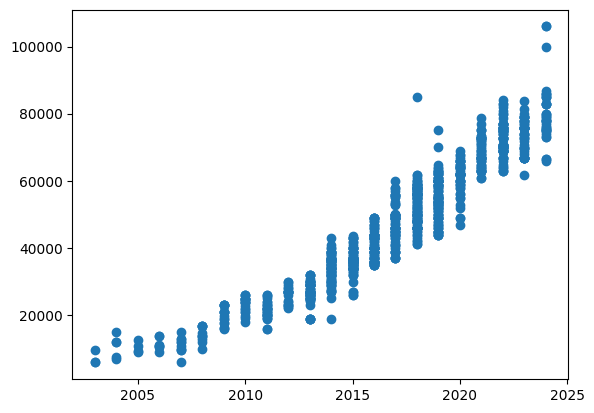

In [28]:
plt.scatter(fil_df['year'].to_numpy(), fil_df['price'].to_numpy())
plt.savefig("city_year_price.png")
plt.show()

In [25]:
df_by_year = fil_df.groupby(['year'])['price'].mean()

In [26]:
df_by_year

year
2003     7166.666667
2004    10615.400000
2005    10325.000000
2006    11282.857143
2007    10958.000000
2008    14324.545455
2009    19879.823529
2010    23070.600000
2011    21425.035714
2012    25946.600000
2013    26750.607143
2014    33745.631579
2015    36085.243590
2016    40813.851351
2017    47108.523077
2018    52446.711712
2019    54736.940594
2020    60900.687500
2021    68462.500000
2022    72479.444444
2023    73658.739130
2024    80210.333333
Name: price, dtype: float64

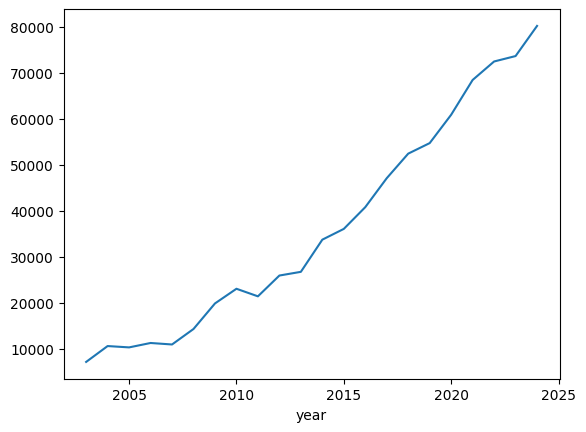

In [29]:
df_by_year.plot()
plt.savefig("city_year_avg_price.png")
plt.show()

In [83]:
pearsonr(fil_df['mileage_mid'].to_numpy(), fil_df['price'].to_numpy())

PearsonRResult(statistic=np.float64(-0.7291382800748321), pvalue=np.float64(2.515141997838e-53))

In [84]:
spearmanr(fil_df['mileage_mid'].to_numpy(), fil_df['price'].to_numpy())

SignificanceResult(statistic=np.float64(-0.7994407725491065), pvalue=np.float64(5.038054432193059e-71))

In [37]:
pearsonr(fil_df['year'].to_numpy(), fil_df['price'].to_numpy())

PearsonRResult(statistic=np.float64(0.9552967062481638), pvalue=np.float64(3.600692736434579e-167))

In [38]:
spearmanr(fil_df['year'].to_numpy(), fil_df['price'].to_numpy())

SignificanceResult(statistic=np.float64(0.9645924163599529), pvalue=np.float64(1.2011384034628273e-182))

# Predictive modelling

## Feature engineering

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [31]:
one_hot_encoder = OneHotEncoder()

locations = df['location'].unique()
locations = locations.reshape(-1, 1)
location_idx_map = {}

for i in range(locations.shape[0]):
    location_idx_map[locations[i][0]] = i

loc_features = one_hot_encoder.fit_transform(locations).toarray()

In [32]:
car_models = df['model'].unique()
car_models = car_models.reshape(-1, 1)
model_idx_map = {}

for i in range(car_models.shape[0]):
    model_idx_map[car_models[i][0]] = i

model_features = one_hot_encoder.fit_transform(car_models).toarray()

In [72]:
features = []
price_labels = []

for i in range(len(df)):
    loc_raw = df['location'].iloc[i]
    loc = loc_features[location_idx_map[loc_raw]]
    model_raw = df['model'].iloc[i]
    model = model_features[model_idx_map[model_raw]]
    year = np.array([df['year'].iloc[i]])
    mileage = np.array([df['mileage_mid'].iloc[i]])
    
    single_feat = np.concatenate((model, loc, year, mileage), axis=0)
 
    features.append(single_feat)
    price_labels.append(df['price'].iloc[i])

features = np.array(features, dtype=np.float32)
price_labels = np.array(price_labels, dtype=np.float32)

train_features, test_features, train_labels, test_labels = train_test_split(features, price_labels, test_size=0.2, random_state=42)

## Training and evaluation

### Linear regression

In [73]:
linear_reg = LinearRegression()
linear_reg.fit(train_features, train_labels)

test_preds = linear_reg.predict(test_features)
mae = mean_absolute_error(test_preds, test_labels)
print("MAE:", mae)

MAE: 21466.168


### AdaBoost

In [74]:
adaboost = AdaBoostRegressor(random_state=0, n_estimators=10)
adaboost.fit(train_features, train_labels)

test_preds = adaboost.predict(test_features)
mae = mean_absolute_error(test_preds, test_labels)
print("MAE:", mae)

MAE: 18247.299575877303


### Neural network

In [76]:
mlp = MLPRegressor(random_state=0, max_iter=300)
mlp.fit(train_features, train_labels)

test_preds = mlp.predict(test_features)
mae = mean_absolute_error(test_preds, test_labels)
print("MAE:", mae)

MAE: 25437.25
